In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\genso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\genso\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\genso\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\genso\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\genso\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
# Read in data
df = pd.read_csv('cyberbullying.csv')

print(df.shape)

(47692, 2)


Text(0, 0.5, 'Count')

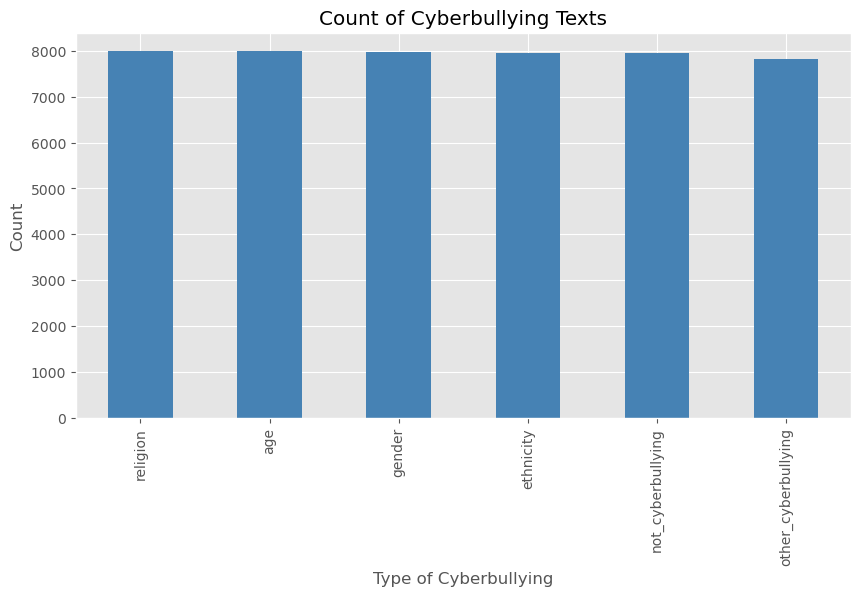

In [39]:
ax = df['cyberbullying_type'].value_counts().plot(
    kind='bar',title= 'Count of Cyberbullying Texts', figsize=(10, 5), color='steelblue')
ax.set_xlabel('Type of Cyberbullying')
ax.set_ylabel('Count')

In [18]:
example = df['tweet_text'][500]
print(example)
example_label = df['cyberbullying_type'][500]
print(example_label)

RT @femfreq: Let me spell it out. It is deeply misogynist to propagate wild conspiracy theories suggesting women in gaming fake death or ra…
not_cyberbullying


In [19]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['RT', '@', 'femfreq', ':', 'Let', 'me', 'spell', 'it', 'out', '.']

In [20]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('RT', 'NNP'),
 ('@', 'NNP'),
 ('femfreq', 'NN'),
 (':', ':'),
 ('Let', 'VB'),
 ('me', 'PRP'),
 ('spell', 'VB'),
 ('it', 'PRP'),
 ('out', 'RP'),
 ('.', '.')]

In [21]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  RT/NNP
  @/NNP
  femfreq/NN
  :/:
  Let/VB
  me/PRP
  spell/VB
  it/PRP
  out/RP
  ./.
  It/PRP
  is/VBZ
  deeply/RB
  misogynist/JJ
  to/TO
  propagate/VB
  wild/JJ
  conspiracy/NN
  theories/NNS
  suggesting/VBG
  women/NNS
  in/IN
  gaming/VBG
  fake/JJ
  death/NN
  or/CC
  ra…/NN)


In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [46]:
sia.polarity_scores(example)

{'neg': 0.331, 'neu': 0.669, 'pos': 0.0, 'compound': -0.886}

In [47]:
# Run polarity scorer on entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['tweet_text']
    res[i] = sia.polarity_scores(text)

    

  0%|          | 0/47692 [00:00<?, ?it/s]

In [48]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = pd.merge(vaders, df.reset_index().rename(columns={'index': 'Id'}), on='Id')

In [69]:
vaders.head()

,Id,neg,neu,pos,compound,tweet_text,cyberbullying_type
0,0,0.000,1.000,0.000,0.0000,"In other words #katandandre, your food was cra...",not_cyberbullying
1,1,0.000,1.000,0.000,0.0000,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,2,0.344,0.442,0.214,-0.4137,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,3,0.237,0.593,0.170,-0.3784,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,4,0.135,0.676,0.188,0.0258,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


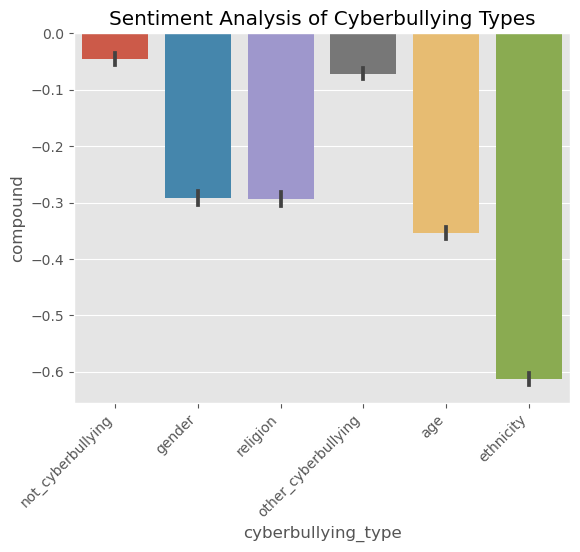

<Figure size 1000x500 with 0 Axes>

In [53]:
ax2 = sns.barplot(data=vaders, x='cyberbullying_type', y='compound')
ax2.set_title('Sentiment Analysis of Cyberbullying Types')

ax2.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.show()

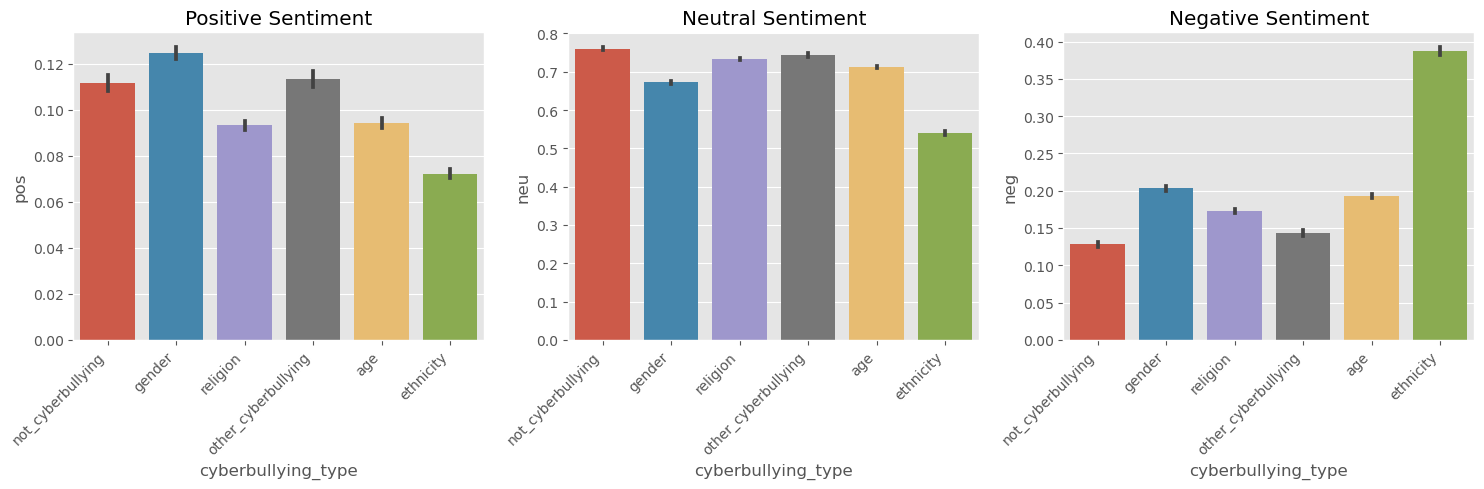

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='cyberbullying_type', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='cyberbullying_type', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='cyberbullying_type', y='neg', ax=axs[2])
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')

for ax in axs.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [58]:
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.8874842, 'roberta_neu': 0.1070881, 'roberta_pos': 0.0054276222}


In [60]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }

In [ ]:
results_df = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['tweet_text']
        vader = {f"vader_{k}": v for k, v in sia.polarity_scores(text).items()}
        res[i] = {**vader, **roberta}
    except RuntimeError:
        print(f"Error processing row {i}")
        continue

  0%|          | 0/47692 [00:00<?, ?it/s]

Error processing row 1317
Error processing row 24516
Error processing row 29205
Error processing row 30752
Error processing row 44035


In [71]:
results_df = pd.DataFrame(res).T.reset_index().rename(columns={'index': 'Id'})
results_df = pd.merge(results_df, df.reset_index().rename(columns={'index': 'Id'}), on='Id')

In [72]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_roberta_neg,roberta_roberta_neu,roberta_roberta_pos,neg,neu,pos,compound,tweet_text,cyberbullying_type
0,0,0.000,1.000,0.000,0.0000,0.872444,0.111914,0.015642,NaN,NaN,NaN,NaN,"In other words #katandandre, your food was cra...",not_cyberbullying
1,1,0.000,1.000,0.000,0.0000,0.354403,0.594232,0.051365,NaN,NaN,NaN,NaN,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,2,0.344,0.442,0.214,-0.4137,0.735626,0.244508,0.019866,NaN,NaN,NaN,NaN,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,3,0.237,0.593,0.170,-0.3784,0.146076,0.428651,0.425273,NaN,NaN,NaN,NaN,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,4,0.135,0.676,0.188,0.0258,0.875830,0.118402,0.005768,NaN,NaN,NaN,NaN,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [73]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_roberta_neg', 'roberta_roberta_neu', 'roberta_roberta_pos',
       'neg', 'neu', 'pos', 'compound', 'tweet_text', 'cyberbullying_type'],
      dtype='object')

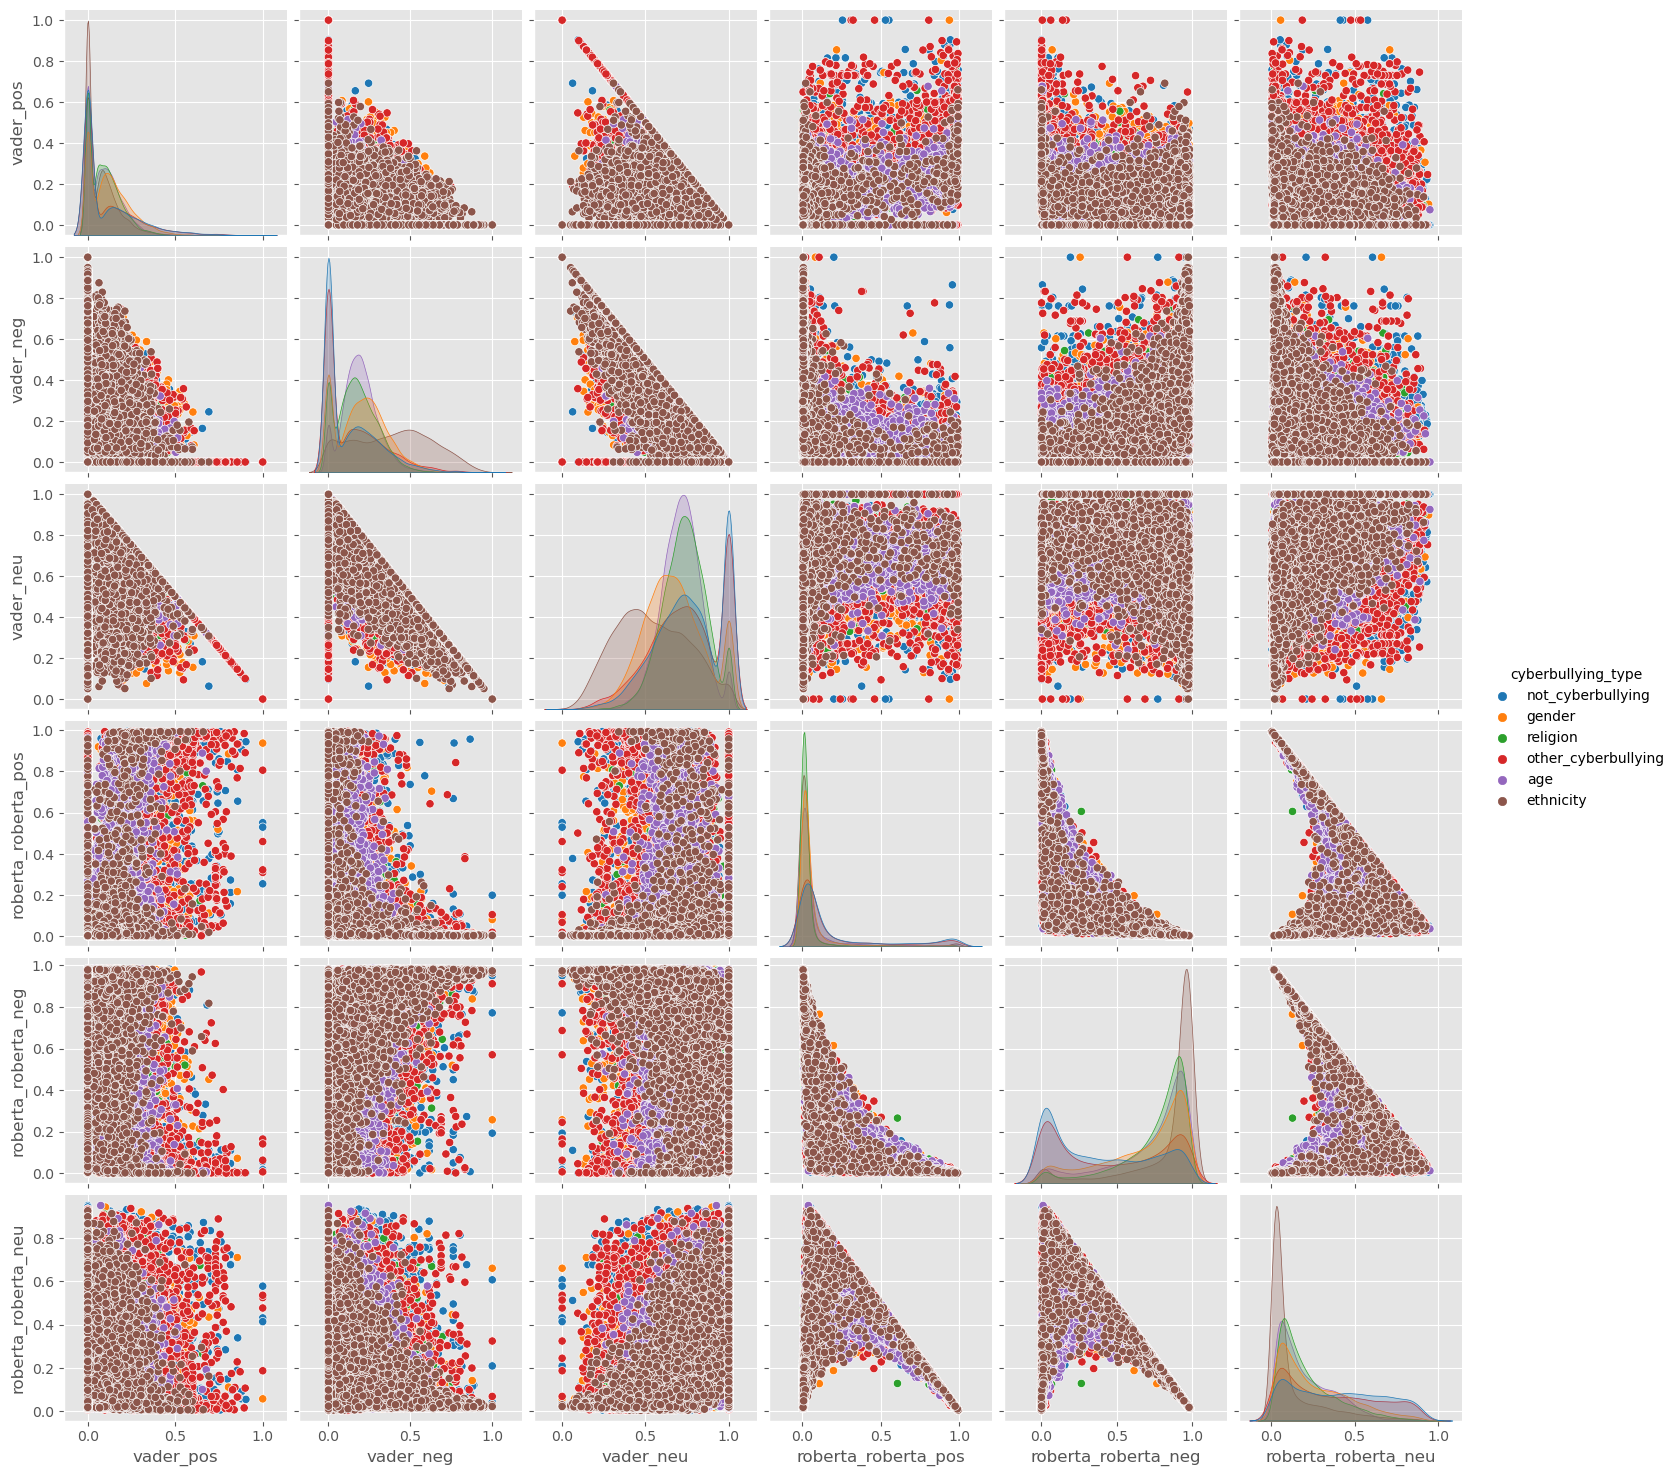

In [76]:
sns.pairplot(results_df, vars=['vader_pos', 'vader_neg', 'vader_neu', 'roberta_roberta_pos', 'roberta_roberta_neg', 'roberta_roberta_neu'],
                    hue='cyberbullying_type', palette='tab10')

In [88]:
results_df.query("cyberbullying_type == 'not_cyberbullying'").sort_values('roberta_roberta_neg', ascending=False).values[0]

array([2965, 0.529, 0.471, 0.0, -0.8782, 0.9842150807380676,
       0.013143633492290974, 0.0026412345468997955, nan, nan, nan, nan,
       'I am so so so so so damn homesick lately i hate it /(',
       'not_cyberbullying'], dtype=object)